**Importing Libraries - numpy, matplotlib and Tensorflow.**

In [1]:
import numpy as np
import PIL
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import glob2
import pickle
import pywhatkit

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Importing images from local directory.**

In [3]:
data_dir = 'F:\TheNewNormal\dataset'
data_dir = pathlib.Path(data_dir) #Using pathlib to convert path to recognizable directory by system(os).

**Setting parameters to process image dataset.**

In [4]:
batch_size = 35 #Creation of batches to reduce runtime load on CPU
image_height = 180
image_width = 180

**Creating dataset from images with above parameters. Also, using 20% dataset for validation.**

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, #Using 20% of dataset to validate model.
  subset="training", #Pushing 80% images to training subset.
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 3416 files belonging to 2 classes.
Using 2733 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, #Using 20% of dataset to validate model.
    subset="validation", #Pushing 20% of images to validation subset
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

Found 3416 files belonging to 2 classes.
Using 683 files for validation.


**Checking classnames - Clean and Garbage.**

In [7]:
class_names = train_ds.class_names
print(class_names)

['Crowded', 'Normal']


**Data Visualization using matplotlib.**

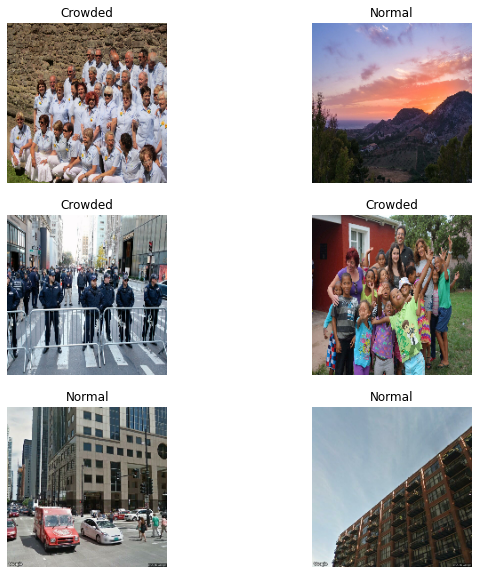

In [8]:
plt.figure(figsize=(10,10)) #setting width and height of image to be displayed to 10X10.
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3,2,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Increasing performance of model by using _dataset.prefetch()_ and _dataset.cache()_ .** 

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # Using prefetch(), during training, data preprocessing and model execution are combined.

**Standarizing data.**

In [10]:
normalization_layer = layers.Rescaling(1./255) #Standarizing values to [0,1] for neural network.

**Creating the model using _Keras_  libraries**

In [11]:
num_classes = 2

model = Sequential([
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),#Generates a tensor of outputs by convolving a convolution kernel with the layer input.
    layers.MaxPooling2D(), #Max pooling operation for 2D spatial data.
    layers.Conv2D(32, 3, padding='same', activation='relu'),#incresing number of filters.
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),#Again, increasing number of filters.
    layers.MaxPooling2D(),
    layers.Flatten(), #Flattens the ouput layer array.
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

**Compiling the model.**

In [12]:
model.compile(optimizer='adam', #Using the Adam optimization technique.
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #Calculates loss
             metrics=['accuracy'])

**Checking summary of model - Output Shapes and Paramaters.**

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

**Training the model.**

In [14]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [15]:
epochs = 9 #Used 9 epochs to get higher confidence level in testing.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/9
79/79 [==============================] - 62s 482ms/step - loss: 0.4834 - accuracy: 0.7845 - val_loss: 0.3401 - val_accuracy: 0.8785
Epoch 2/9
79/79 [==============================] - 36s 455ms/step - loss: 0.2536 - accuracy: 0.9093 - val_loss: 0.3258 - val_accuracy: 0.8917
Epoch 3/9
79/79 [==============================] - 38s 485ms/step - loss: 0.2099 - accuracy: 0.9184 - val_loss: 0.3486 - val_accuracy: 0.8887
Epoch 4/9
79/79 [==============================] - 39s 490ms/step - loss: 0.1489 - accuracy: 0.9440 - val_loss: 0.3543 - val_accuracy: 0.8858
Epoch 5/9
79/79 [==============================] - 48s 605ms/step - loss: 0.0787 - accuracy: 0.9740 - val_loss: 0.4169 - val_accuracy: 0.8624
Epoch 6/9
79/79 [==============================] - 43s 548ms/step - loss: 0.0627 - accuracy: 0.9769 - val_loss: 0.4361 - val_accuracy: 0.8697
Epoch 7/9
79/79 [==============================] - 38s 485ms/step - loss: 0.0219 - accuracy: 0.9956 - val_loss: 0.5738 - val_accuracy: 0.8609
Epoch 

**Visualizing training results using matplotlib - Accuracy and Losses in graphs.**

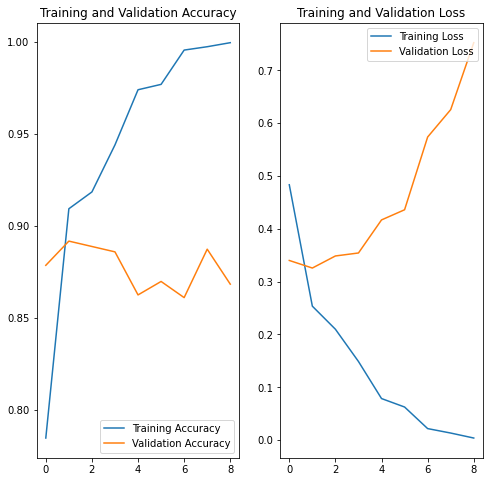

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8)) 
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

**Testing model on new images.**

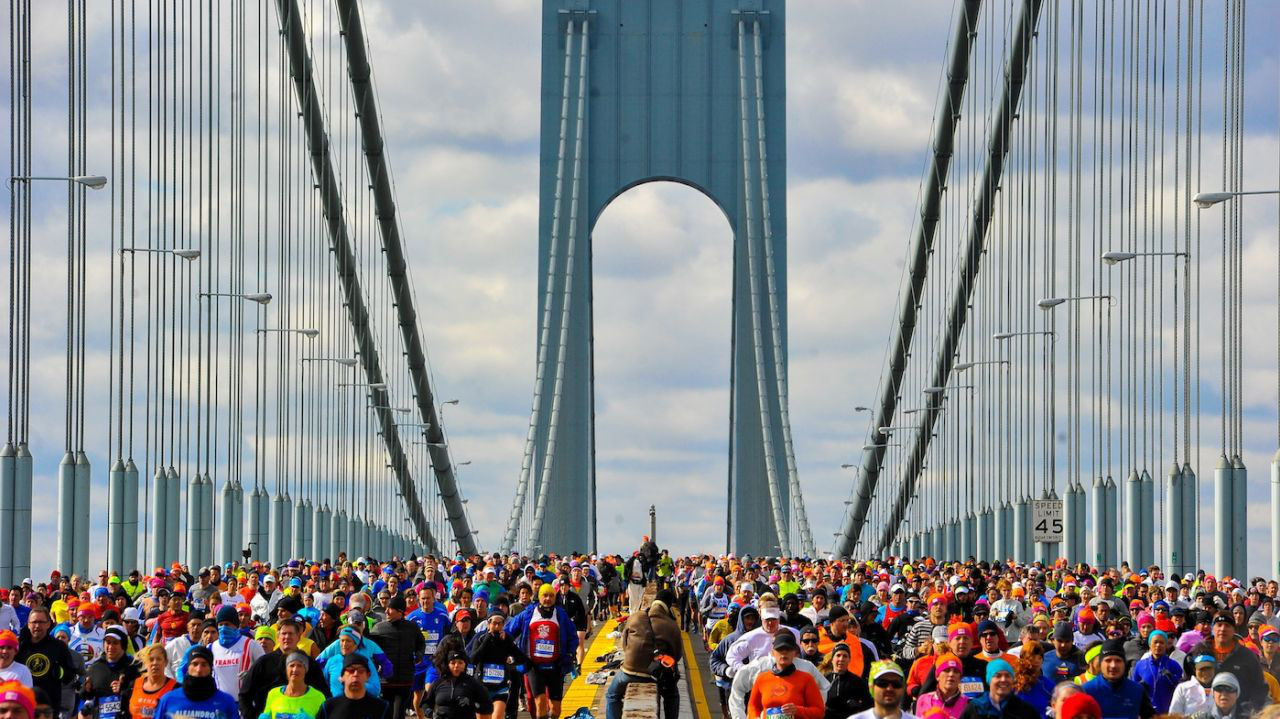

This image most likely belongs to Crowded with a 99.99 percent confidence
In 28 seconds web.whatsapp.com will open and after 20 seconds message will be delivered


In [54]:
from PIL import Image
from IPython.display import display
img_path = './test_crowd/marathon.jpg'

display(Image.open(img_path))

img = tf.keras.utils.load_img(
    img_path, target_size=(image_height, image_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence"
     .format(class_names[np.argmax(score)], 100 * np.max(score))
     )

from datetime import datetime

now = datetime.now()

curr_hour = int(now.strftime("%H"))
curr_min = int(now.strftime("%M"))

if(class_names[np.argmax(score)] == "Crowded"):
    pywhatkit.sendwhatmsg("+918769325604", "Crowded at Location XYZ", curr_hour, curr_min+1)
else:
    print("\n","Everything's Fine")